# 4D change analysis of near-continuous LiDAR time series for applications in geomorphic monitoring

## Time series-based change analysis of surface dynamics using time series clustering

In this notebook we will perform time series-based surface change analysis on a time series of permanent TLS point clouds of the sandy beach at Kijkduin for a timespan of around 6 months (<a href="#references">Vos et al., 2022</a>).
An introduction to the case study and dataset can be found [here](https://3dgeo-heidelberg.github.io/etrainee/module3/06_casestudy_sandybeach/06_casestudy_sandybeach.html). 

The objective is to assess surface dynamics with time series clustering (following <a href="#references">Kuschnerus et al., 2021</a>). Look into the related article for comparison of possible surface dynamics of the use case and help for deciding on suitable parameters, etc.

The workflow is introduced throughout this notebook. You can also make use of the software documentations!


## Software and data
This task is solved using Python with the [`py4dgeo`](https://github.com/3dgeo-heidelberg/py4dgeo) library. 

You can use CloudCompare or GIS Software (e.g. QGIS) to check the data and visualize your results.

The dataset is a subsampled version of the original time series, using 12-hourly epochs of point clouds and spatial subsampling to 50 cm. The dataset [can be downloaded](https://zenodo.org/records/10003575) (module3.zip) from the E-learning course E-TRAINEE. In the data directory `kijkduin`, you find the prepared input point clouds and a core points point cloud, which is manually cleaned from noise.

[E-TRAINEE](https://github.com/3dgeo-heidelberg/etrainee) is an e-learning course on Time Series Analysis in Remote Sensing for Understanding Human-Environment Interactions. This course has been developed by research groups from four partner universities – Charles University, Heidelberg University, University of Innsbruck, and University of Warsaw.

## Loading data and calculation of surface changes

We first prepare the analysis by compiling the list of files (epochs) and reading the timestamps from the file names (format `YYMMDD_hhmmss`) into `datetime` objects. Use the point cloud files and timestamps to create a py4dgeo `SpatiotemporalAnalysis` object. For this we need to instantiate the M3C2 algorithm. We can use the point cloud file `170115_150816_aoi_50cm.laz` as core points. Explore the point cloud properties in CloudCompare: 

* Considering the available point density and surface characteristics, what would be a suitable cylinder radius for the distance calculation?
* What would be a suitable approach to derive the surface normals in this topography and expected types of surface changes?

Hint: In this flat topography and predominant provess of sand deposition and erosion, it can be suitable to orient the normals purely vertically. In this case, they do not need to be computed, and you can [customize the py4dgeo algorithm](https://py4dgeo.readthedocs.io/en/latest/customization.html#Changing-search-directions) accordingly.

We use the first point cloud in the time series (list of files) as reference epoch. We can assume a registration error of 1.9 cm for the M3C2 distance calculation (cf. <a href="#references">Vos et al., 2022</a>).

The spatiotemporal change information can be explored by visualizing the changes at a selected epoch and visualizing the time series at a selected location. 

First, we start by setting up the Python environment and data:

In [1]:
# import required modules
import os
import numpy as np
import py4dgeo
from datetime import datetime
import pooch

# Download data from zenodo and set path to point cloud folder
p = pooch.Pooch(base_url="doi:10.5281/zenodo.10003574/", path=pooch.os_cache("py4dgeo"))
p.load_registry_from_doi()
p.fetch("module3.zip", processor=pooch.Unzip())
pc_dir = os.path.join(p.path, "module3.zip.unzip/module3/kijkduin", "pointclouds")

# Remove zip file if it exists from previous executions of the notebook
unwanted_file = os.path.join(pc_dir, "kijkduin.zip")
if os.path.exists(unwanted_file):
    os.remove(unwanted_file)

# list of point clouds (time series)
pc_list = os.listdir(pc_dir)
pc_list[:5]  # print the first elements

['kijkduin_170117_120041.laz',
 'kijkduin_170118_000050.laz',
 'kijkduin_170120_120036.laz',
 'kijkduin_170121_000046.laz',
 'kijkduin_170121_120055.laz']

In the list of point cloud files we can see that we have one laz file per epoch available. The file name contains the timestamp of the epoch, respectively, in format `YYMMDD_hhmmss`. To use this information for our analysis, we read the timestamp information from the file names into `datetime` objects.

In [2]:
# read the timestamps from file names
timestamps = []
for f in pc_list:
    if not f.endswith(".laz"):
        continue

    # get the timestamp from the file name
    timestamp_str = "_".join(f.split(".")[0].split("_")[1:])  # yields YYMMDD_hhmmss

    # convert string to datetime object
    timestamp = datetime.strptime(timestamp_str, "%y%m%d_%H%M%S")
    timestamps.append(timestamp)

timestamps[:5]

[datetime.datetime(2017, 1, 17, 12, 0, 41),
 datetime.datetime(2017, 1, 18, 0, 0, 50),
 datetime.datetime(2017, 1, 20, 12, 0, 36),
 datetime.datetime(2017, 1, 21, 0, 0, 46),
 datetime.datetime(2017, 1, 21, 12, 0, 55)]

Now we use the point cloud files and timestamp information to create a `SpatiotemporalAnalysis` object.

In [3]:
analysis = py4dgeo.SpatiotemporalAnalysis(f"{pc_dir}/kijkduin.zip", force=True)

[2023-12-01 14:03:12][INFO] Creating analysis file C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds/kijkduin.zip


As reference epoch, we use the first epoch in our time series:

In [4]:
# specify the reference epoch
reference_epoch_file = os.path.join(pc_dir, pc_list[0])

# read the reference epoch and set the timestamp
reference_epoch = py4dgeo.read_from_las(reference_epoch_file)
reference_epoch.timestamp = timestamps[0]

# set the reference epoch in the spatiotemporal analysis object
analysis.reference_epoch = reference_epoch

[2023-12-01 14:03:14][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170117_120041.laz'
[2023-12-01 14:03:14][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:14][INFO] Saving epoch to file 'C:\Users\ep413\AppData\Local\Temp\tmp5tj65crt\reference_epoch.zip'
[2023-12-01 14:03:14][INFO] Saving a file without normals.


For epochs to be added, we now configure the M3C2 algorithm to derive the change values. We would like to set the normals purely vertically, so we define a customized computation of cylinder `directions`:

In [5]:
# Inherit from the M3C2 algorithm class to define a custom direction algorithm
class M3C2_Vertical(py4dgeo.M3C2):
    def directions(self):
        return np.array([0, 0, 1])  # vertical vector orientation


# specify corepoints, here all points of the reference epoch
analysis.corepoints = reference_epoch.cloud[::]

# specify M3C2 parameters for our custom algorithm class
analysis.m3c2 = M3C2_Vertical(
    cyl_radii=(1.0,), max_distance=10.0, registration_error=0.019
)

[2023-12-01 14:03:17][INFO] Initializing Epoch object from given point cloud
[2023-12-01 14:03:17][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:17][INFO] Saving epoch to file 'C:\Users\ep413\AppData\Local\Temp\tmp_e9qhauw\corepoints.zip'
[2023-12-01 14:03:17][INFO] Saving a file without normals.


Now we add all the other epochs with their timestamps:

In [6]:
# create a list to collect epoch objects
epochs = []
for e, pc_file in enumerate(pc_list[1:]):
    epoch_file = os.path.join(pc_dir, pc_file)
    epoch = py4dgeo.read_from_las(epoch_file)
    epoch.timestamp = timestamps[e]
    epochs.append(epoch)

# add epoch objects to the spatiotemporal analysis object
analysis.add_epochs(*epochs)

# print the spatiotemporal analysis data for 3 corepoints and 5 epochs, respectively
print(f"Space-time distance array:\n{analysis.distances[:3,:5]}")
print(
    f"Uncertainties of M3C2 distance calculation:\n{analysis.uncertainties['lodetection'][:3, :5]}"
)
print(f"Timestamp deltas of analysis:\n{analysis.timedeltas[:5]}")

[2023-12-01 14:03:20][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170118_000050.laz'
[2023-12-01 14:03:20][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170120_120036.laz'
[2023-12-01 14:03:20][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170121_000046.laz'
[2023-12-01 14:03:20][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170121_120055.laz'
[2023-12-01 14:03:20][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170123_120045.laz'
[2023-12-01 14:03:20][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:03:21][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170306_000043.laz'
[2023-12-01 14:03:22][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170306_120051.laz'
[2023-12-01 14:03:22][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170307_000058.laz'
[2023-12-01 14:03:22][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170308_120026.laz'
[2023-12-01 14:03:22][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170309_000036.laz'
[2023-12-01 14:03:22][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:03:23][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170416_120029.laz'
[2023-12-01 14:03:23][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170417_000037.laz'
[2023-12-01 14:03:23][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170417_120047.laz'
[2023-12-01 14:03:23][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170418_120004.laz'
[2023-12-01 14:03:23][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170419_000013.laz'
[2023-12-01 14:03:23][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:03:24][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170511_000043.laz'
[2023-12-01 14:03:24][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170512_000002.laz'
[2023-12-01 14:03:24][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170512_120011.laz'
[2023-12-01 14:03:24][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170513_000019.laz'
[2023-12-01 14:03:24][INFO] Reading point cloud from file 'C:\Users\ep413\AppData\Local\py4dgeo\py4dgeo\Cache\module3.zip.unzip/module3/kijkduin\pointclouds\kijkduin_170513_120030.laz'
[2023-12-01 14:03:24][INFO] Reading point cloud from file 'C:\Users\ep413\A

[2023-12-01 14:03:28][INFO] Starting: Adding epoch 16/159 to analysis object
[2023-12-01 14:03:28][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:29][INFO] Finished in 0.2603s: Adding epoch 16/159 to analysis object
[2023-12-01 14:03:29][INFO] Starting: Adding epoch 17/159 to analysis object
[2023-12-01 14:03:29][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:29][INFO] Finished in 0.2552s: Adding epoch 17/159 to analysis object
[2023-12-01 14:03:29][INFO] Starting: Adding epoch 18/159 to analysis object
[2023-12-01 14:03:29][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:29][INFO] Finished in 0.2555s: Adding epoch 18/159 to analysis object
[2023-12-01 14:03:29][INFO] Starting: Adding epoch 19/159 to analysis object
[2023-12-01 14:03:29][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:29][INFO] Finished in 0.2551s: Adding epoch 19/159 to analysis object
[2023-12-01 14:03:29][INFO] Star

[2023-12-01 14:03:37][INFO] Starting: Adding epoch 50/159 to analysis object
[2023-12-01 14:03:37][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:37][INFO] Finished in 0.2369s: Adding epoch 50/159 to analysis object
[2023-12-01 14:03:37][INFO] Starting: Adding epoch 51/159 to analysis object
[2023-12-01 14:03:37][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:37][INFO] Finished in 0.2384s: Adding epoch 51/159 to analysis object
[2023-12-01 14:03:37][INFO] Starting: Adding epoch 52/159 to analysis object
[2023-12-01 14:03:37][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:37][INFO] Finished in 0.2476s: Adding epoch 52/159 to analysis object
[2023-12-01 14:03:37][INFO] Starting: Adding epoch 53/159 to analysis object
[2023-12-01 14:03:37][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:38][INFO] Finished in 0.2389s: Adding epoch 53/159 to analysis object
[2023-12-01 14:03:38][INFO] Star

[2023-12-01 14:03:45][INFO] Starting: Adding epoch 84/159 to analysis object
[2023-12-01 14:03:45][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:45][INFO] Finished in 0.2412s: Adding epoch 84/159 to analysis object
[2023-12-01 14:03:45][INFO] Starting: Adding epoch 85/159 to analysis object
[2023-12-01 14:03:45][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:45][INFO] Finished in 0.2391s: Adding epoch 85/159 to analysis object
[2023-12-01 14:03:45][INFO] Starting: Adding epoch 86/159 to analysis object
[2023-12-01 14:03:45][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:46][INFO] Finished in 0.2382s: Adding epoch 86/159 to analysis object
[2023-12-01 14:03:46][INFO] Starting: Adding epoch 87/159 to analysis object
[2023-12-01 14:03:46][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:46][INFO] Finished in 0.2376s: Adding epoch 87/159 to analysis object
[2023-12-01 14:03:46][INFO] Star

[2023-12-01 14:03:53][INFO] Starting: Adding epoch 118/159 to analysis object
[2023-12-01 14:03:53][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:53][INFO] Finished in 0.2367s: Adding epoch 118/159 to analysis object
[2023-12-01 14:03:53][INFO] Starting: Adding epoch 119/159 to analysis object
[2023-12-01 14:03:53][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:53][INFO] Finished in 0.2384s: Adding epoch 119/159 to analysis object
[2023-12-01 14:03:53][INFO] Starting: Adding epoch 120/159 to analysis object
[2023-12-01 14:03:53][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:54][INFO] Finished in 0.2354s: Adding epoch 120/159 to analysis object
[2023-12-01 14:03:54][INFO] Starting: Adding epoch 121/159 to analysis object
[2023-12-01 14:03:54][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:03:54][INFO] Finished in 0.2384s: Adding epoch 121/159 to analysis object
[2023-12-01 14:03:54][IN

[2023-12-01 14:04:01][INFO] Finished in 0.2323s: Adding epoch 151/159 to analysis object
[2023-12-01 14:04:01][INFO] Starting: Adding epoch 152/159 to analysis object
[2023-12-01 14:04:01][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:04:01][INFO] Finished in 0.2374s: Adding epoch 152/159 to analysis object
[2023-12-01 14:04:01][INFO] Starting: Adding epoch 153/159 to analysis object
[2023-12-01 14:04:01][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:04:01][INFO] Finished in 0.2322s: Adding epoch 153/159 to analysis object
[2023-12-01 14:04:01][INFO] Starting: Adding epoch 154/159 to analysis object
[2023-12-01 14:04:01][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:04:02][INFO] Finished in 0.2341s: Adding epoch 154/159 to analysis object
[2023-12-01 14:04:02][INFO] Starting: Adding epoch 155/159 to analysis object
[2023-12-01 14:04:02][INFO] Building KDTree structure with leaf parameter 10
[2023-12-01 14:04:02][IN

We visualize the changes in the scene for a selected epoch, together with the time series of surface changes at a selected location. The location here was selected separately in CloudCompare (as the corepoint id).

[2023-12-01 14:07:52][INFO] Restoring epoch from file 'C:\Users\ep413\AppData\Local\Temp\tmpdm333kcj\reference_epoch.zip'


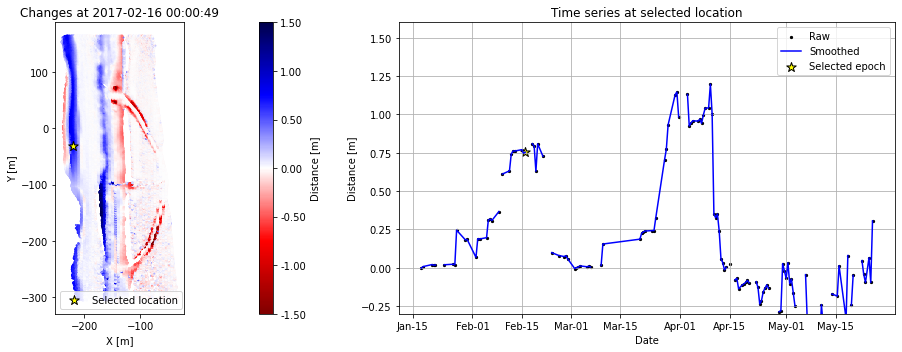

In [7]:
cp_idx_sel = 15162  # selected core point index
epoch_idx_sel = 28  # selected epoch index

# import plotting module
import matplotlib.pyplot as plt

# allow interactive rotation in notebook
%matplotlib inline

# create the figure
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# get the corepoints
corepoints = analysis.corepoints.cloud

# get change values of last epoch for all corepoints
distances = analysis.distances
distances_epoch = [d[epoch_idx_sel] for d in distances]

# get the time series of changes at a specific core point locations
coord_sel = analysis.corepoints.cloud[cp_idx_sel]
timeseries_sel = distances[cp_idx_sel]

# get the list of timestamps from the reference epoch timestamp and timedeltas
timestamps = [t + analysis.reference_epoch.timestamp for t in analysis.timedeltas]

# plot the scene
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    c=distances_epoch[:],
    cmap="seismic_r",
    vmin=-1.5,
    vmax=1.5,
    s=1,
    zorder=1,
)
plt.colorbar(d, format=("%.2f"), label="Distance [m]", ax=ax1, pad=0.15)

# add the location of the selected coordinate
ax1.scatter(
    coord_sel[0],
    coord_sel[1],
    facecolor="yellow",
    edgecolor="black",
    s=100,
    zorder=2,
    label="Selected location",
    marker="*",
)
ax1.legend()

# configure the plot layout
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_aspect("equal")
ax1.set_title(
    "Changes at %s"
    % (analysis.reference_epoch.timestamp + analysis.timedeltas[epoch_idx_sel])
)

# plot the time series
ax2.scatter(timestamps, timeseries_sel, s=5, color="black", label="Raw")
ax2.plot(timestamps, timeseries_sel, color="blue", label="Smoothed")
ax2.set_xlabel("Date")

# add the epoch of the plotted scene
ax2.scatter(
    timestamps[epoch_idx_sel],
    timeseries_sel[epoch_idx_sel],
    facecolor="yellow",
    marker="*",
    edgecolor="black",
    s=100,
    color="red",
    label="Selected epoch",
)
ax2.legend()

# format the date labels
import matplotlib.dates as mdates

dtFmt = mdates.DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(dtFmt)

# configure the plot layout
ax2.set_ylabel("Distance [m]")
ax2.grid()
ax2.set_ylim(-0.3, 1.6)
ax2.set_title("Time series at selected location")

plt.tight_layout()
plt.show()

The map of changes in the scene shows us linear structures of sand deposition near the coast which can be interpreted as sand bars (with knowledge about coastal processes). This is confirmed by the surface behavior over time, expressed in the time series plot. However, the time series is quite noisy especially in this part of the beach, which is regularly covered by water during high tides (leading to missing data) and also varies strongly in surface moisture (influencing the LiDAR range measurement and causing noise). We therefore continue with temporal smoothing of the time series.

## Temporal smoothing

You are dealing with a temporal subset of the original hourly time series. The effect of temporal measurement variability may therefore be less pronounced (compared to the assessment in, e.g., [Anders et al., 2019](#references)). Nonetheless, you may apply temporal smoothing to reduce the influence of noise on your change analysis using a rolling median averaging of one week. This will also fill possible gaps in your data, e.g., lower ranges during poor atmospheric conditions or no data due to water coverage during tides on the lower beach part. 

Visualize the raw and smoothed change values in the time series of your selected location.

We apply a rolling median with a defined temporal window of 14 epochs (corresponding to one week of 12-hourly point clouds) using the `temporal_averaging()` function in py4dgeo.

In [8]:
analysis.smoothed_distances = py4dgeo.temporal_averaging(
    analysis.distances, smoothing_window=14
)

[2023-12-01 14:08:05][INFO] Starting: Smoothing temporal data
[2023-12-01 14:08:27][INFO] Finished in 21.7022s: Smoothing temporal data


Now we can compare the raw and smoothed time series at our selected location:

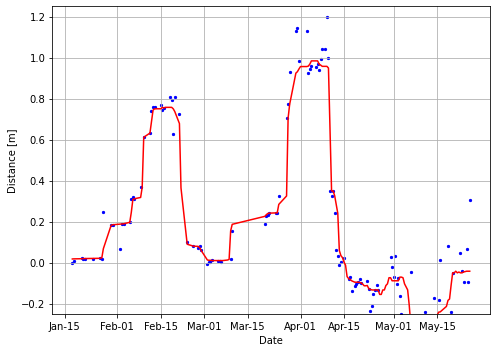

In [9]:
# create the figure
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# plot the raw time series
ax.scatter(timestamps, timeseries_sel, color="blue", label="raw", s=5)

# plot the smoothed time series
timeseries_sel_smooth = analysis.smoothed_distances[cp_idx_sel]
ax.plot(timestamps, timeseries_sel_smooth, color="red", label="smooth")

# format the date labels
import matplotlib.dates as mdates

dtFmt = mdates.DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(dtFmt)

# add plot elements
ax.set_xlabel("Date")
ax.set_ylabel("Distance [m]")
ax.grid()
ax.set_ylim(-0.25, 1.25)

plt.tight_layout()
plt.show()

From the smoothed time series at the selected location, we can now much better interpret the surface behavior. In fact, we can distinctly observe that there were two consecutive occurrences of temporary deposition of several weeks. These represent two phases where sand bars are present. They can be extracted as individual objects by the 4D objects-by-change method. Before, we continue with time series clustering and the assessment of overall change patterns in the following.

## Time series clustering
To derive characteristic change patterns on the sandy beach, we now perform k-means clustering of the time series following <a href="#references">Kuschnerus et al. (2021)</a>. We will assess the clustering for different selections of `k` numbers of clusters.

* Can you interpret the characteristics of different parts on the beach? Visualize example time series for different clusters.
* From which number of clusters do you see a clear separation in overall units of the beach area?
* What are some detail change patterns that become visible for a higher number of clusters?


We perform k-means clustering for a set of `k`s at once and collect the resulting labels for subsequent assessment:

In [1]:
# import kmeans clustering module from scikit-learn
from sklearn.cluster import KMeans

# use the smoothed distances for clustering
distances = analysis.smoothed_distances

# define the number of clusters
ks = [5, 10, 20, 50]

# create an array to store the labels
labels = np.full((distances.shape[0], len(ks)), np.nan)

# perform clustering for each number of clusters
for kidx, k in enumerate(ks):
    print(f"Performing clustering with k={k}...")
    nan_indicator = np.logical_not(np.isnan(np.sum(distances, axis=1)))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(distances[nan_indicator, :])
    labels[nan_indicator, kidx] = kmeans.labels_

NameError: name 'analysis' is not defined

Now we can visualize the resulting change patterns for different numbers of clusters:

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 7))
(ax1, ax2, ax3, ax4) = axs

cmap_clustering = "tab20"
sc1 = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    c=labels[:, 0],
    cmap=cmap_clustering,
    s=1,
    label=ks[0],
)

sc2 = ax2.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    c=labels[:, 1],
    cmap=cmap_clustering,
    s=1,
    label=ks[1],
)

sc3 = ax3.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    c=labels[:, 2],
    cmap=cmap_clustering,
    s=1,
    label=ks[2],
)

sc4 = ax4.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    c=labels[:, 3],
    cmap=cmap_clustering,
    s=1,
    label=ks[3],
)

ax_c = 0
for ax in axs:
    ax.set_aspect("equal")
    ax.set_title(f"# clusters = {ks[ax_c]}")
    ax_c += 1

plt.tight_layout()
plt.show()

When using a small number of clusters (k=5), a large part of the beach is assigned to one cluster of assumingly little activity (gray area). From our exploration of changes in the scene at a selected epoch above, we further obtain two clusters with mainly deposition (blue clusters) and one cluster in the erosion areas around the pathway through the dunes. With a higher number of clusters (k=10 to k=50), the coarser clusters are further split up into (assumingly) finer patterns.

We can look into the time series properties within selected clusters, to interpret the change pattern they are representing. Here, we will check the clusters derived with k=10 by plotting the median values of all time series per cluster:

In [ ]:
# create the figure
fig, axs = plt.subplots(1, 2, figsize=(12, 7))
ax1, ax2 = axs

# get the labels for the selected number of clusters
labels_k = labels[:, 1]

# plot the map of clusters
sc = ax1.scatter(
    corepoints[:, 0], corepoints[:, 1], c=labels_k, cmap=cmap_clustering, s=1
)

# plot the time series representing the clusters (median of each cluster)
for l in np.unique(labels_k):
    ax2.plot(
        timestamps,
        np.nanmedian(distances[labels_k == l, :], axis=0),
        label=f"cluster {l}",
    )

# format the date labels
import matplotlib.dates as mdates

dtFmt = mdates.DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(dtFmt)

# add plot elements
ax1.set_aspect("equal")
ax1.set_title(f"# clusters = {ks[1]}")
ax2.set_xlabel("Date")
ax2.set_ylabel("Distance [m]")
ax2.grid()

plt.tight_layout()
plt.show()

Now we can relate the temporal behavior to the spatial clusters. For example, we see strong and sudden surface increases for the orange and red clusters (with different timing and magnitude). The gray cluster (occuring in two spatial extents) represents sand bars, which we know from our time series example above. The large coverage of the brown cluster shows a time series with little activity - except for fluctuations, especially towards the end of the observation period, which is contained in all clusters. We can assume that this represents some measurement effects in the data that could not be corrected by the preprocessing and alignment procedure ([Vos et al., 2022]).

<a id='references'></a>
# References

* Anders, K., Lindenbergh, R. C., Vos, S. E., Mara, H., de Vries, S., & Höfle, B. (2019). High-Frequency 3D Geomorphic Observation Using Hourly Terrestrial Laser Scanning Data Of A Sandy Beach. ISPRS Ann. Photogramm. Remote Sens. Spatial Inf. Sci., IV-2/W5, pp. 317-324. doi: [10.5194/isprs-annals-IV-2-W5-317-2019](https://doi.org/10.5194/isprs-annals-IV-2-W5-317-2019).
* Anders, K., Winiwarter, L., Mara, H., Lindenbergh, R., Vos, S. E., & Höfle, B. (2021). Fully automatic spatiotemporal segmentation of 3D LiDAR time series for the extraction of natural surface changes. ISPRS Journal of Photogrammetry and Remote Sensing, 173, pp. 297-308. doi: [10.1016/j.isprsjprs.2021.01.015](https://doi.org/10.1016/j.isprsjprs.2021.01.015).
* Kuschnerus, M., Lindenbergh, R., & Vos, S. (2021). Coastal change patterns from time series clustering of permanent laser scan data. Earth Surface Dynamics, 9 (1), pp. 89-103. doi: [10.5194/esurf-9-89-2021](https://doi.org/10.5194/esurf-9-89-2021).
* Vos, S., Anders, K., Kuschnerus, M., Lindenberg, R., Höfle, B., Aarnikhof, S. & Vries, S. (2022). A high-resolution 4D terrestrial laser scan dataset of the Kijkduin beach-dune system, The Netherlands.  Scientific Data, 9:191. doi: [10.1038/s41597-022-01291-9](https://doi.org/10.1038/s41597-022-01291-9).